# About

These is a base solution of PID.

In [1]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import XGBoostClassifier

# Directories

In [2]:
track = 'Long'
particle = 'Electron'

data_path = "../../../data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long"

work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
"multiclass/Long/Keras"

netconfig_path = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_Long_ANN.txt"

# Read data

In [3]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
labs = [0, 1, 2, 3, 4, 5]

In [9]:
data = pandas.read_csv(data_path + "/data_train.csv")

In [20]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

# Balance data

In [21]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  170119
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  774220
Size of class 4 is  138261
Size of class 5 is  81951


In [22]:
selected_indexes = []

numpy.random.seed = 42

for i in numpy.unique(labels):
    
    indxs = numpy.random.choice(data.index[labels == i], 
                                size=min(50000, len(labels[labels == i])), 
                                replace=False)
    
    selected_indexes += list(indxs)

In [23]:
data.loc[selected_indexes].to_csv(data_path + "/data_train_balanced.csv")

# Read balanced data

In [4]:
data = pandas.read_csv(data_path + "/data_train_balanced.csv")

In [5]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [6]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  50000
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  50000
Size of class 4 is  50000
Size of class 5 is  50000


# Features

In [7]:
features = [
 'BremPIDe',
 'CaloNeutralPrs',
 'CaloNeutralSpd',
 'InAccBrem',
 'InAccSpd',
 'CaloPrsE',
 'InAccPrs',
 'HcalPIDe',
 'CaloHcalE',
 'InAccHcal',
 'CaloTrajectoryL',
 'EcalPIDe',
 'CaloNeutralEcal',
 'CaloTrMatch',
 'CaloElectronMatch',
 'CaloChargedPrs',
 'CaloChargedSpd',
 'MuonNShared',
 'CaloBremMatch',
 'MuonIsLooseMuon',
 'MuonIsMuon',
 'MuonBkgLL',
 'InAccEcal',
 'MuonMuLL',
 #'TrackMatchChi2', # all missing values
 'TrackGhostProbability',
 'TrackType',
 'EcalPIDmu',
 'TrackPt',
 'TrackP',
 'RichAboveMuThres',
 'InAccMuon',
 'TrackChi2PerDof',
 'TrackNumDof',
 'CombDLLmu',
 'CaloSpdE',
 'PrsPIDe',
 'HcalPIDmu',
 'TrackFitMatchChi2',
 'CombDLLpi',
 'RichDLLbt',
 'TrackHistory',
 'RichDLLpi',
 'TrackFitVeloNDoF',
 'CombDLLp',
 'TrackFitTChi2',
 'TrackFitTNDoF',
 'RichAboveElThres',
 'TrackDOCA',
 'RichDLLe',
 'CombDLLe',
 'CombDLLk',
 'TrackFitVeloChi2',
 'RichDLLp',
 'RichUsedR1Gas',
 'RichUsedR2Gas',
 'CaloEcalE',
 'RichAbovePiThres',
 'CaloChargedEcal',
 'RichAboveKaThres',
 'RichAbovePrThres',
 'RichDLLmu',
 'RichDLLk']
#  'piplus_OWNPV_X',
#  'piplus_OWNPV_Y',
#  'piplus_OWNPV_Z',
#  'piplus_OWNPV_XERR',
#  'piplus_OWNPV_YERR',
#  'piplus_OWNPV_ZERR',
#  'piplus_OWNPV_CHI2',
#  'piplus_OWNPV_NDOF',
#  'piplus_IP_OWNPV',
#  'piplus_IPCHI2_OWNPV']

In [8]:
len(features)

62

# Feature histograms

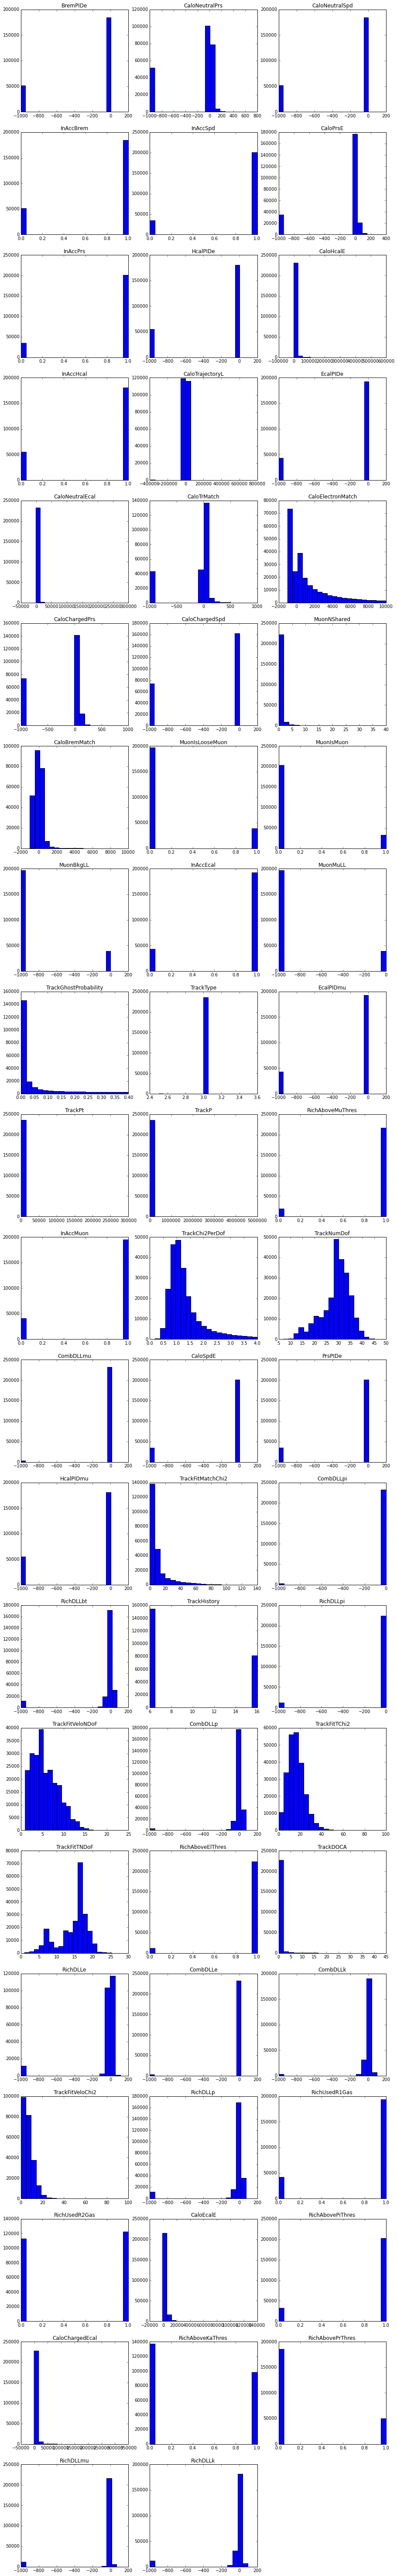

In [9]:
i=0
plt.figure(figsize=(15, 5 * (len(features)//3 + 1)))

for f in features:
    
    plt.subplot(len(features)//3 + 1, 3, i+1)
    plt.title(f)
    plt.hist(data[f].values, bins=20)
    
    i+=1
    
plt.show()

# Preprocessing

In [10]:
from sklearn.preprocessing import MinMaxScaler, Imputer, StandardScaler

class Preprocessor(object):
    
    def __init__(self, features, missing_values, with_missing_masks=True, copy=True):
        self.features = features
        self.missing_values = missing_values
        self.with_missing_masks = with_missing_masks
        self.copy = copy
        
    def fit(self, data):
        
        self.ss_dict = {}
        self.imputer_dict = {}
        self.mms_dict = {}
        
        for f in self.features:
            
            feature_value = data[f].values.reshape((-1, 1))
            feature_non_missing = feature_value[feature_value != self.missing_values].reshape((-1, 1))
            
            if len(feature_non_missing) == 0:
                print f + ' has all missing values.'
                
            imputer = Imputer(missing_values=self.missing_values, strategy='median', axis=0, copy=False)
            imputer.fit(feature_non_missing)
            self.imputer_dict[f] = imputer
                
            mms = MinMaxScaler(feature_range=(0, 100), copy=False)
            mms.fit(feature_non_missing)
            self.mms_dict[f] = mms
            feature_non_missing = mms.transform(feature_non_missing)
            sing = (feature_non_missing > 0) * 2. - 1.
            feature_non_missing = numpy.log(1. + numpy.abs(feature_non_missing)) * sing
            #feature_non_missing = 1./feature_non_missing
            
            ss = StandardScaler(copy=False, with_mean=True, with_std=True)
            ss.fit(feature_non_missing)
            self.ss_dict[f] = ss
            
    def transform(self, data):
        
        if self.copy == True:
            input_data = data.copy()
        else:
            input_data = data
        
        self.new_features = []
        
        for f in self.features:
            
            feature_value = input_data[f].values.reshape((-1, 1))
            missing_mask = (feature_value != self.missing_values) * 1.
            
            feature_value = self.imputer_dict[f].transform(feature_value)
            
            feature_value = self.mms_dict[f].transform(feature_value)
            sing = (feature_value > 0) * 2. - 1.
            feature_value = numpy.log(1. + numpy.abs(feature_value)) * sing
            #feature_value = 1./feature_value
            
            feature_value = self.ss_dict[f].transform(feature_value)
            
            input_data[f] = feature_value.reshape(-1)
            if self.with_missing_masks == True:
                input_data[f + 'not_missing'] = missing_mask
                self.new_features += [f + 'not_missing']
                
        return input_data[features + self.new_features]

In [11]:
prep = Preprocessor(features=features, missing_values=-999., with_missing_masks=True, copy=True)
prep.fit(data)

In [12]:
output = prep.transform(data)

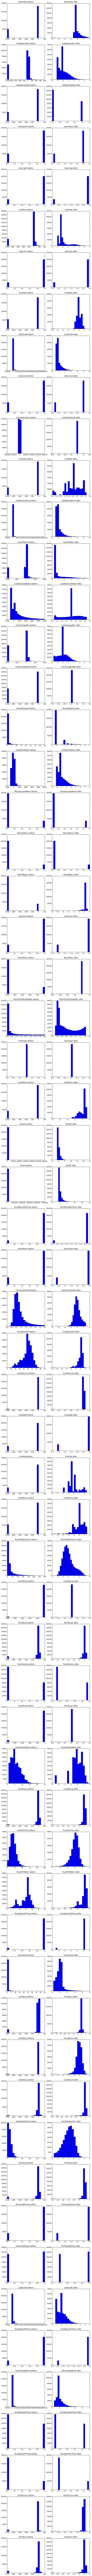

In [13]:
i = 1
plt.figure(figsize=(10, 5 * len(features)))

for f in features:
    
    plt.subplot(len(features),2,i)
    plt.title(f + ' before')
    plt.hist(data[f].values, bins=20)
    
    plt.subplot(len(features),2,i+1)
    plt.title(f + ' after')
    plt.hist(output[f].values, bins=20)
    
    i += 2
    
plt.show()

# Train Keras

In [14]:
weights = numpy.zeros(len(labels))

for one_lab in labs:
    
    weights += 0.1 * (labels == one_lab) * len(labels) / ((labels == one_lab).sum())
    
numpy.unique(weights)

array([ 0.470898  ,  0.78906465,  4.19695187])

In [15]:
for i in numpy.unique(labels):
    print "Weight of class %d is " % i, weights[labels == i][0]

Weight of class 0 is  0.470898
Weight of class 1 is  4.19695187166
Weight of class 2 is  0.789064646939
Weight of class 3 is  0.470898
Weight of class 4 is  0.470898
Weight of class 5 is  0.470898


In [16]:
from sklearn.cross_validation import train_test_split

train_inds, test_inds, labels_train, labels_test, weights_train, weights_test = train_test_split(data.index, 
                                                                                                 labels, 
                                                                                                 weights, 
                                                                                                 test_size=0.25, 
                                                                                                 random_state=42)

In [18]:
from keras.utils import np_utils

X_train = prep.transform(data.loc[train_inds]).values
y_train = np_utils.to_categorical(labels_train)

X_test = prep.transform(data.loc[test_inds]).values
y_test = np_utils.to_categorical(labels_test)

In [20]:
int(1.4 * len(features + prep.new_features))

173

In [ ]:
%%time
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adadelta
from keras.callbacks import EarlyStopping
from keras.regularizers import l2, activity_l2, l1, activity_l1, l1l2

clf = Sequential()
clf.add(Dense(int(1.4 * len(features + prep.new_features)), 
              input_dim=len(features + prep.new_features), init='uniform', activation='sigmoid'))
#clf.add(Activation('sigmoid'))
#clf.add(Dropout(0.5))
clf.add(Dense(6, init='uniform', activation='softmax'))
#clf.add(Activation('sigmoid'))
#clf.add(Activation('softmax'))

ada = Adadelta(lr=1., rho=0.95, epsilon=1e-06)
sgd = SGD(lr=0.01, decay=0.0, momentum=0.0, nesterov=False)

clf.compile(loss='categorical_crossentropy',
              optimizer=sgd,
             class_mode = "categorical")

call = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')


history = clf.fit(X=X_train, 
                y=y_train, 
                #sample_weight=weights_train,
                nb_epoch=700,
                batch_size=128,
                show_accuracy=True,
                validation_split=0.1,
                validation_data = (X_test, y_test),
                verbose=0,
                callbacks=[call])

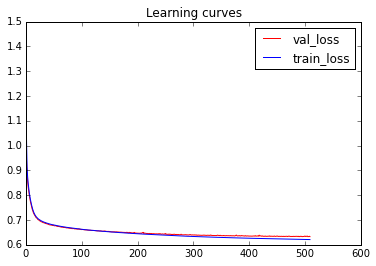

In [27]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.title('Learning curves')
plt.plot(val_loss, 'r', label='val_loss')
plt.plot(loss, 'b', label='train_loss')
plt.legend(loc='best')
plt.show()

# Save the classifier

In [ ]:
new_work_path = work_path + "/001"
new_work_path

In [ ]:
# Save classifier
import os
if not os.path.exists(new_work_path):
    os.makedirs(new_work_path)

clf_pickle = open(new_work_path + '/classifier.pkl', 'wb')
pickle.dump(clf, clf_pickle)
clf_pickle.close()

In [7]:
# new_work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/\
# multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;base_score=0.5;\
# n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=50;colsample=0.7;max_depth=8;gamma=None;nthreads=4;\
# balanced_data_235449"

In [8]:
# Read classifier
# clf_pickle2 = open(new_work_path + '/classifier.pkl', 'rb')
# clf = pickle.load(clf_pickle2)
# clf_pickle2.close()

# Test the classifier

In [28]:
probas = clf.predict_proba(X_test)
#probas = theanets_base.predict_proba(preprocessing.transform(data[features].loc[test_inds].values))

58863/58863 [==============================] - 2s     


In [29]:
probas[:5, :]

array([[  2.33824219e-04,   1.36613002e-04,   9.46412092e-06,
          4.37204173e-04,   4.76651281e-01,   5.22531629e-01],
       [  3.68673285e-03,   9.64617266e-06,   6.05322475e-06,
          2.24327086e-03,   9.15148497e-01,   7.89058134e-02],
       [  9.38109934e-01,   2.62983982e-02,   9.42836143e-03,
          1.26302419e-02,   9.71082691e-03,   3.82221537e-03],
       [  8.67399752e-01,   4.99751586e-05,   1.58217400e-02,
          4.15350944e-02,   1.74556244e-02,   5.77377938e-02],
       [  6.69716075e-02,   4.62543219e-03,   3.41782510e-01,
          4.78631377e-01,   5.19506186e-02,   5.60384765e-02]])

### Logloss

In [30]:
from sklearn.metrics import log_loss

log_loss(labels_test, probas)

0.6331297329379556

### Roc curves

In [31]:
import os, sys
sys.path.append('../python')
import utils

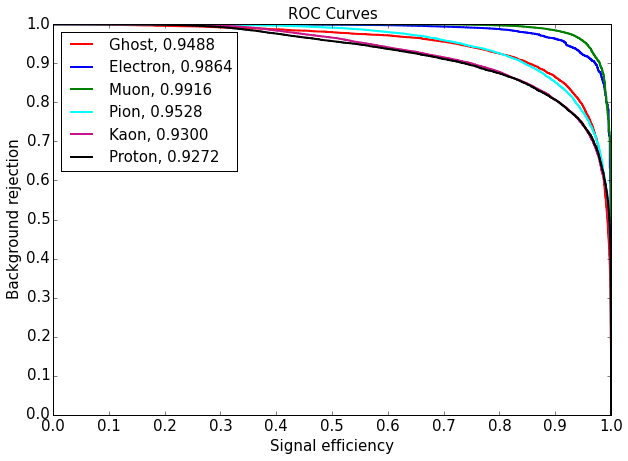

In [32]:
utils.get_roc_curves(labels_test, probas, particles, save_path=None, show=True)

# Evaluation

In [33]:
import os, sys
sys.path.append('../python')
import utils

In [34]:
data_eval = pandas.read_csv(data_path + "/data_eval.csv")

In [35]:
mc_p_type_eval = numpy.abs(data_eval.MCParticleType.values)
labels_eval = numpy.zeros(len(mc_p_type_eval))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels_eval += one_lab * (mc_p_type_eval == pdg)
    
numpy.unique(labels_eval)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [36]:
numpy.isnan(data_eval[features].values).sum()

0

In [37]:
X_eval = prep.transform(data_eval).values

In [38]:
proba_eval = clf.predict_proba(X_eval)

1000000/1000000 [==============================] - 36s    


In [39]:
#numpy.savetxt(new_work_path + '/xgboost_proba_eval.csv', proba_eval)

In [40]:
#proba_eval = numpy.loadtxt(new_work_path + '/xgboost_proba_eval.csv')

In [41]:
proba_eval[:5, :]

array([[  2.58397311e-03,   2.96895299e-03,   9.16390680e-04,
          1.34773254e-02,   1.92197174e-01,   7.87856162e-01],
       [  7.45620579e-04,   1.21993462e-05,   5.47261493e-07,
          7.67487145e-05,   4.99223441e-01,   4.99941438e-01],
       [  7.62238773e-03,   4.19353455e-06,   3.40257818e-03,
          9.80017781e-01,   5.55271842e-03,   3.40032694e-03],
       [  9.67791528e-02,   6.00929335e-02,   4.53326944e-03,
          5.50222158e-01,   1.35755062e-01,   1.52617440e-01],
       [  6.11024629e-03,   6.73002546e-07,   7.22043624e-05,
          9.93614316e-01,   1.61468954e-04,   4.10988432e-05]])

### Get all figures from baseline

In [18]:
from get_figures import all_figures

In [19]:
for num in range(0, len(particles)):
        
    one_particle = particles[num]
    one_lab = labs[num]

    one_labels = (labels_eval == one_lab)*1
    one_probas = numpy.concatenate((1.-proba_eval[:, num].reshape(-1,1), proba_eval[:, num].reshape(-1,1)),axis=1)
    
    params = {}
    params['PARTICLE'] = one_particle
    params['TRACK'] = 'Long'
    
    all_figures(params, data_eval, one_probas, one_labels, features, path= new_work_path + "/"+ one_particle +"/pic")

### Logloss

In [42]:
from sklearn.metrics import log_loss

logloss = log_loss(labels_eval, proba_eval)
numpy.savetxt(new_work_path + '/logloss_eval.csv', [logloss])
logloss

0.60306713935885958

### Roc curves, roc auc matrix and roc auc ratio matrix

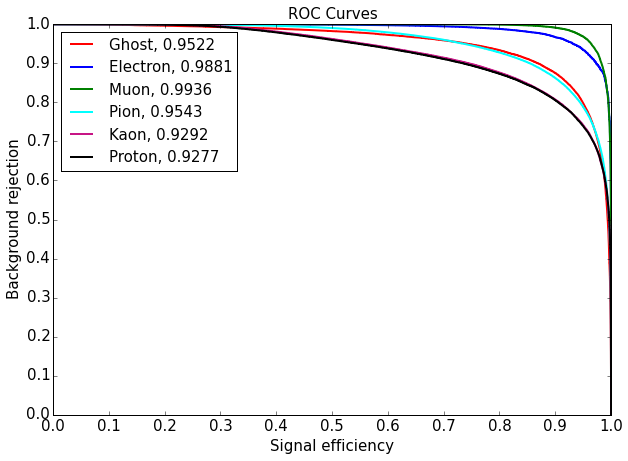

In [43]:
utils.get_roc_curves(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)

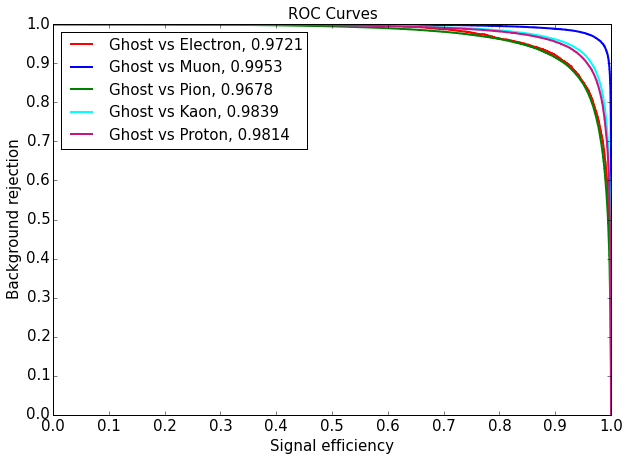

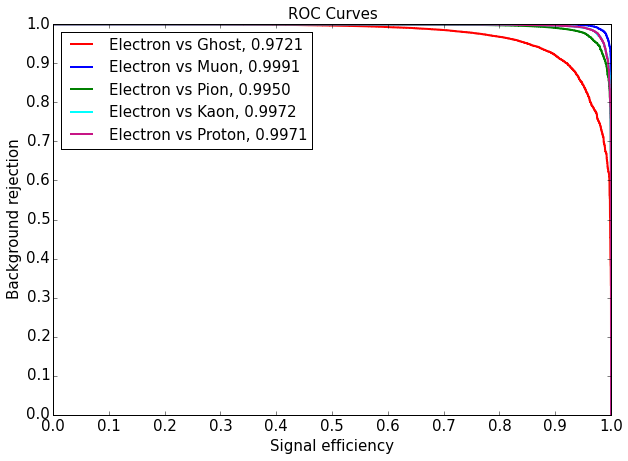

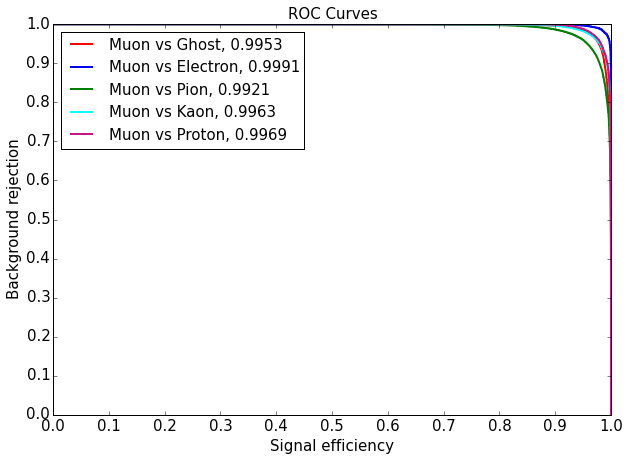

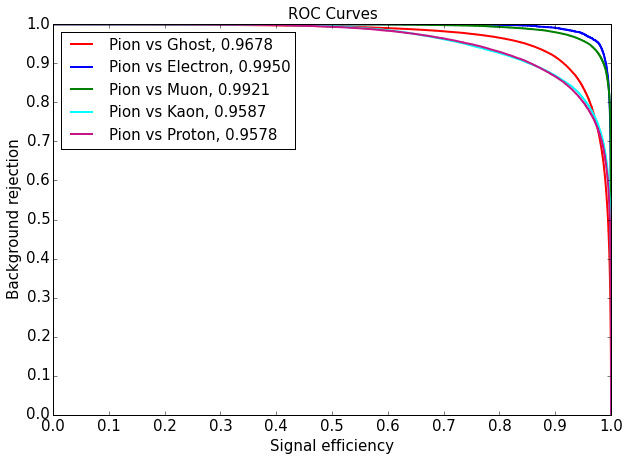

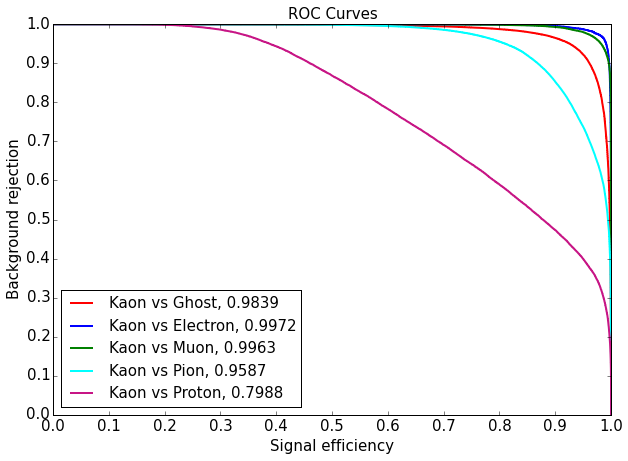

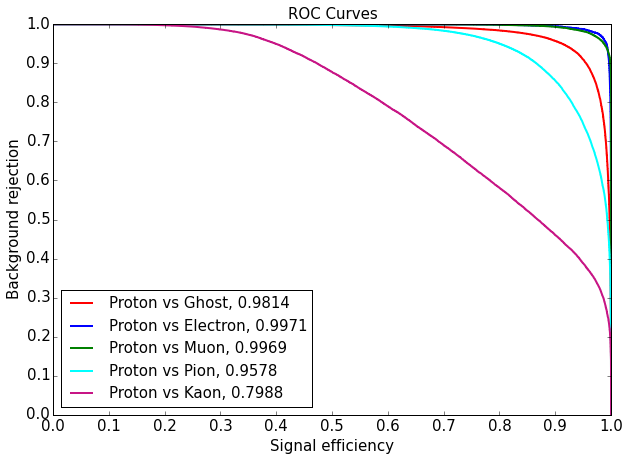

In [47]:
utils.get_one_vs_one_roc_curves(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


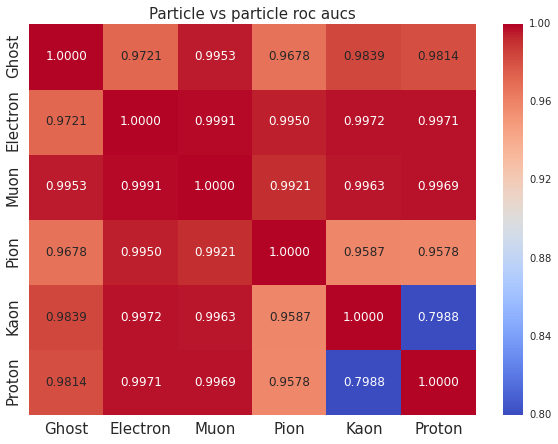

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,0.972066,0.995339,0.967818,0.983899,0.981372
Electron,0.972066,1.000000,0.999132,0.995018,0.997208,0.997114
Muon,0.995339,0.999132,1.000000,0.992063,0.996270,0.996931
Pion,0.967818,0.994974,0.992063,1.000000,0.958724,0.957842
Kaon,0.983899,0.997208,0.996269,0.958724,1.000000,0.798843
Proton,0.981372,0.997114,0.996931,0.957842,0.798843,1.000000


In [44]:
roc_auc_matrix = utils.get_roc_auc_matrix(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)
roc_auc_matrix

In [45]:
roc_auc_matrix_baseline = pandas.read_csv("../python/class_vs_class_roc_auc_matrix_baseline.csv", index_col=0)

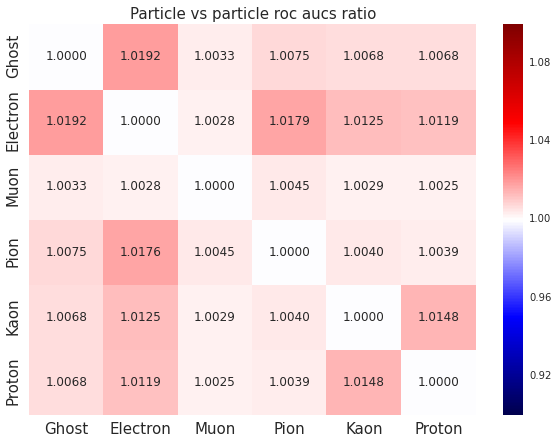

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,1.019184,1.003337,1.007461,1.006817,1.006802
Electron,1.019185,1.000000,1.002754,1.017927,1.012513,1.011939
Muon,1.003337,1.002751,1.000000,1.004547,1.002911,1.002472
Pion,1.007461,1.017639,1.004521,1.000000,1.003967,1.003860
Kaon,1.006817,1.012546,1.002911,1.003967,1.000000,1.014829
Proton,1.006802,1.011934,1.002472,1.003859,1.014829,1.000000


In [46]:
utils.get_roc_auc_ratio_matrix(roc_auc_matrix, roc_auc_matrix_baseline, save_path=new_work_path, show=True)

In [48]:

mean = 0
for one in range(0, 6):
    for two in range(0, 6):
        if one >= two:
            continue
        mean += roc_auc_matrix.iloc[one, two] / 15
        
mean

0.97264257135619125

### Flatness

In [49]:
%%time
flatness = utils.get_flatness_table(data_eval, labels_eval, proba_eval, particles, save_path=new_work_path)

CPU times: user 18min 9s, sys: 32 ms, total: 18min 9s
Wall time: 18min 9s


In [50]:
flatness

,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
Ghost,0.005092,0.021891,0.000873,0.000866
Electron,0.009599,0.033914,0.000998,0.000959
Muon,0.023595,0.037522,0.000888,0.000892
Pion,0.016930,0.014835,0.000850,0.000849
Kaon,0.046109,0.031000,0.000877,0.000873
Proton,0.037206,0.042715,0.000891,0.000879


In [54]:
flatness[['TrackP', 'TrackPt']].values.mean()

0.026700608324888891

In [51]:
flatness_baseline = pandas.read_csv("../python/flatness_baseline.csv", index_col=0)
flatness_baseline

,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
Electron,0.006546,0.016579,0.001014,0.001004
Proton,0.034632,0.044571,0.000886,0.000888
Pion,0.016512,0.013729,0.000853,0.000851
Muon,0.020388,0.044991,0.000905,0.000906
Kaon,0.043074,0.036657,0.000872,0.000880
Ghost,0.006591,0.014187,0.000871,0.000870


In [52]:
utils.get_flatness_ratio(flatness, flatness_baseline, save_path=new_work_path)

,TrackP,TrackPt
Ghost,0.772635,1.542970
Electron,1.466361,2.045576
Muon,1.157292,0.833978
Pion,1.025328,1.080607
Kaon,1.070469,0.845677
Proton,1.074312,0.958355


### Efficiency curves

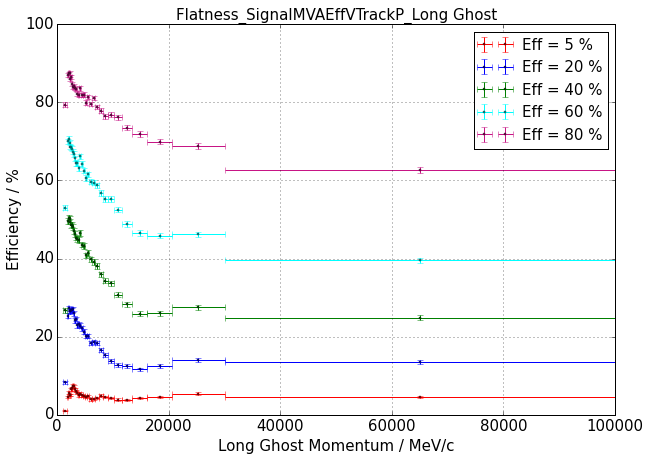

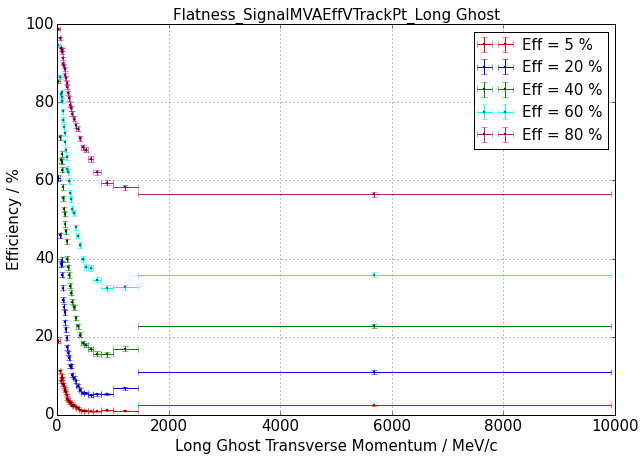

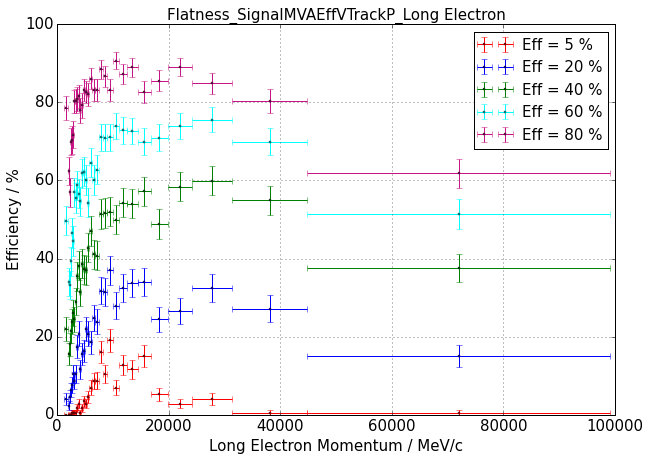

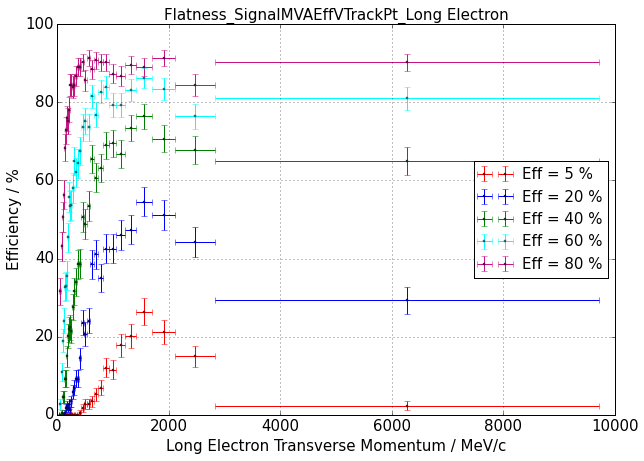

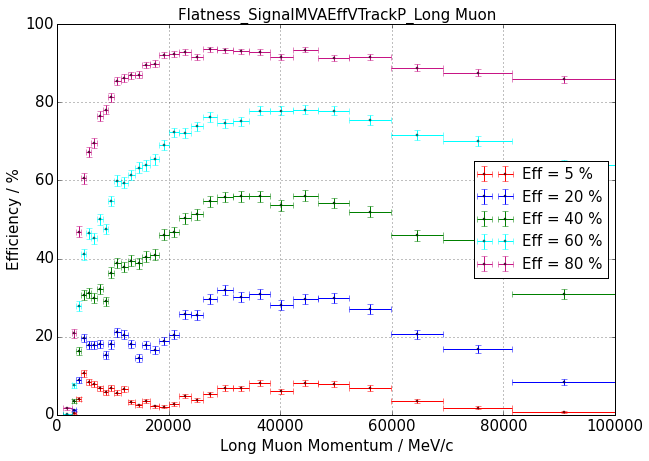

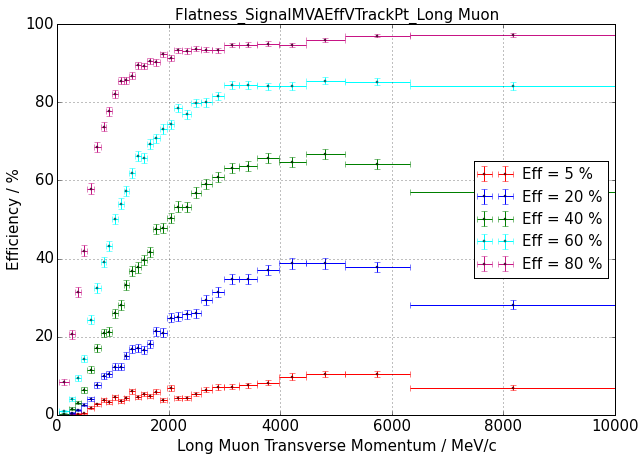

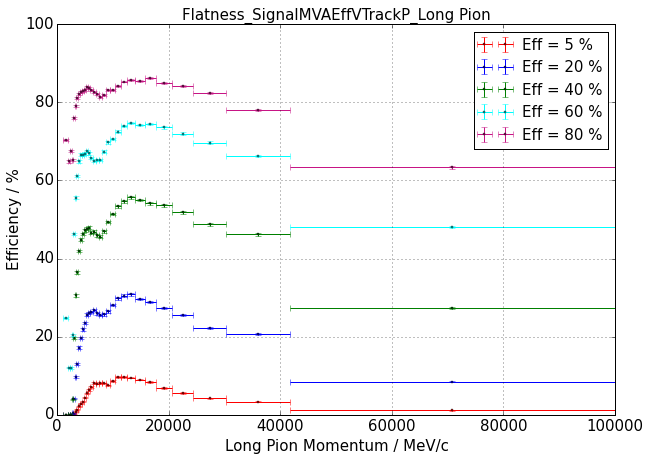

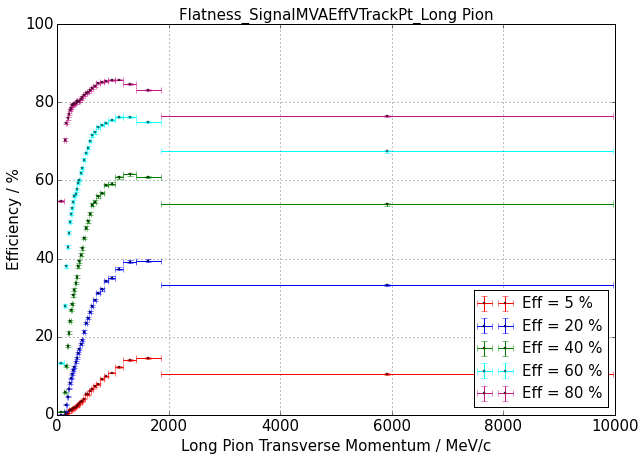

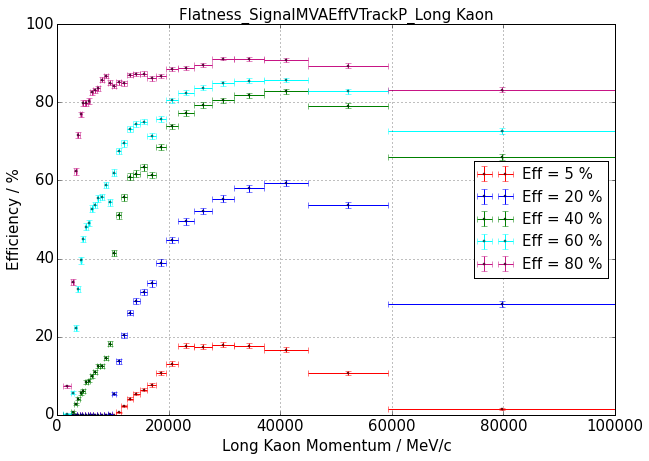

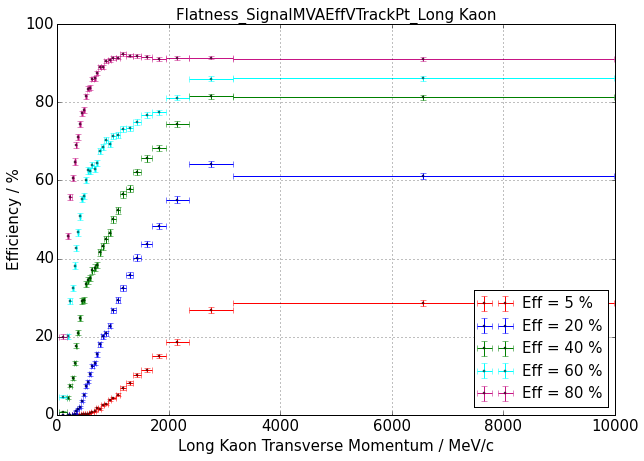

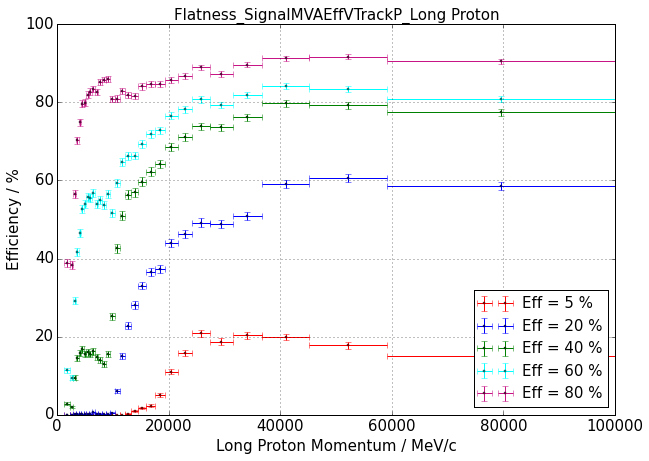

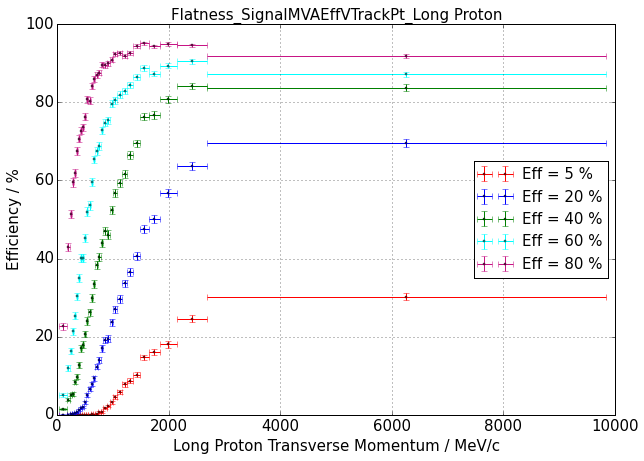

In [53]:
utils.get_all_flatness_figures(data_eval, proba_eval, labels_eval, 'Long', particles, save_path=new_work_path, show=True)